In [1]:
import numpy as np
import kagglehub
import pickle
import cv2

from os import listdir
import tensorflow
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/vectra/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-29 14:10:36.768632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-29 14:10:37.072818: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-29 14:10:36.768632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see

In [2]:
gpus = tensorflow.config.list_physical_devices('GPU')
print('GPUs:', gpus)
if gpus:
    try:
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
        print('Enabled memory growth for GPUs')
    except Exception as e:
        print('Could not set memory growth:', e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = kagglehub.dataset_download("emmarex/plantdisease")

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((256, 256))
image_size = 0
directory_root = path+'/plantvillage/'
width=256
height=256
depth=3

In [5]:
from pathlib import Path
from collections import defaultdict

# Sanity-check the dataset root
_dr = Path(directory_root).resolve()
print(f"[INFO] directory_root = {_dr}")
print(f"[INFO] Exists: {_dr.exists()}  Is dir: {_dr.is_dir()}")

if _dr.exists() and _dr.is_dir():
    subdirs = [p for p in _dr.iterdir() if p.is_dir()]
    print(f"[INFO] Top-level subfolders: {len(subdirs)}")
    # Show a few subfolders and quick image counts
    exts = {'.jpg', '.jpeg', '.png', '.bmp'}
    for p in sorted(subdirs)[:8]:
        try:
            files = [f for f in p.iterdir() if f.is_file() and f.suffix.lower() in exts]
            print(f" - {p.name}: {len(files)} images directly inside")
        except Exception as e:
            print(f" - {p.name}: [WARN] error listing -> {e}")
else:
    print("[WARN] directory_root missing or not a folder. Verify dataset download path.")

[INFO] directory_root = /home/vectra/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/plantvillage
[INFO] Exists: True  Is dir: True
[INFO] Top-level subfolders: 1
 - PlantVillage: 0 images directly inside


In [6]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
from pathlib import Path

ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
MAX_PER_CLASS = 300  # to keep a cap similar to your previous sampling


def _find_class_dirs(root: Path):
    class_dirs = []
    for p in root.iterdir():
        if not p.is_dir():
            continue
        # Case 1: class folders exist directly under root
        try:
            imgs_here = any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in p.iterdir())
        except Exception:
            imgs_here = False
        if imgs_here:
            class_dirs.append(p)
            continue
        # Case 2: there's an extra grouping level (e.g., color/segmented -> classes)
        try:
            for sub in p.iterdir():
                if sub.is_dir():
                    imgs_sub = any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in sub.iterdir())
                    if imgs_sub:
                        class_dirs.append(sub)
        except Exception:
            pass
    # Deduplicate and sort by name
    return sorted(set(class_dirs), key=lambda x: x.name)

image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root = Path(directory_root)
    if not root.exists() or not root.is_dir():
        raise FileNotFoundError(f"Dataset root not found: {root}")

    class_dirs = _find_class_dirs(root)
    print(f"[INFO] Detected {len(class_dirs)} class folders.")

    per_class_counts = {}
    for cdir in class_dirs:
        try:
            files = [f for f in cdir.iterdir() if f.is_file() and f.suffix.lower() in ALLOWED_EXTS]
        except Exception:
            files = []
        files = sorted(files)[:MAX_PER_CLASS]
        per_class_counts[cdir.name] = len(files)

        for fp in files:
            arr = convert_image_to_array(str(fp))
            if arr is None or (hasattr(arr, "size") and arr.size == 0):
                continue
            image_list.append(arr)
            label_list.append(cdir.name)

    print("[INFO] Image loading completed")
    print("[INFO] Per-class counts (capped):")
    for k, v in sorted(per_class_counts.items()):
        print(f" - {k}: {v}")
    print(f"[INFO] Total images: {len(image_list)}; Total labels: {len(label_list)}")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Detected 15 class folders.
[INFO] Image loading completed
[INFO] Per-class counts (capped):
 - Pepper__bell___Bacterial_spot: 300
 - Pepper__bell___healthy: 300
 - Potato___Early_blight: 300
 - Potato___Late_blight: 300
 - Potato___healthy: 152
 - Tomato_Bacterial_spot: 300
 - Tomato_Early_blight: 300
 - Tomato_Late_blight: 300
 - Tomato_Leaf_Mold: 300
 - Tomato_Septoria_leaf_spot: 300
 - Tomato_Spider_mites_Two_spotted_spider_mite: 300
 - Tomato__Target_Spot: 300
 - Tomato__Tomato_YellowLeaf__Curl_Virus: 300
 - Tomato__Tomato_mosaic_virus: 300
 - Tomato_healthy: 300
[INFO] Total images: 4352; Total labels: 4352
[INFO] Image loading completed
[INFO] Per-class counts (capped):
 - Pepper__bell___Bacterial_spot: 300
 - Pepper__bell___healthy: 300
 - Potato___Early_blight: 300
 - Potato___Late_blight: 300
 - Potato___healthy: 152
 - Tomato_Bacterial_spot: 300
 - Tomato_Early_blight: 300
 - Tomato_Late_blight: 300
 - Tomato_Leaf_Mold: 300
 - Tomato_Septoria_

In [8]:
image_size = len(image_list)


    

In [9]:
# Prepare stratified split and fit label binarizer on train only
labels_np = np.array(label_list)
idx = np.arange(len(labels_np))
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    idx, test_size=0.2, random_state=42, stratify=labels_np
)

label_binarizer = LabelBinarizer()
label_binarizer.fit(labels_np[train_idx])
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)
import pickle
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [10]:
np_image_list = np.array(image_list, dtype=np.float32) / 255.0

In [11]:
print("[INFO] Splitting data to train, test (stratified)")
x_train = np_image_list[train_idx]
x_test = np_image_list[test_idx]
y_train = label_binarizer.transform(labels_np[train_idx])
y_test = label_binarizer.transform(labels_np[test_idx])
print(f"Train: {x_train.shape}, Test: {x_test.shape}, Classes: {n_classes}")

[INFO] Splitting data to train, test (stratified)
Train: (3481, 256, 256, 3), Test: (871, 256, 256, 3), Classes: 15
Train: (3481, 256, 256, 3), Test: (871, 256, 256, 3), Classes: 15


In [12]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Use global pooling instead of flatten to avoid huge dense weight matrices
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes, kernel_regularizer=l2(1e-4)))
model.add(Activation("softmax"))

/home/vectra/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761761447.357039    6457 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 85, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 85, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 85, 85, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 85, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 42, 42, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 42, 42, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 58,102,671 (221.64 MB)

 Trainable params: 58,099,791 (221.63 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [15]:
opt = Adam(learning_rate=INIT_LR)
# For single-label multi-class classification, use categorical_crossentropy with mild label smoothing
loss = tensorflow.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
]

In [17]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/30


2025-10-29 14:10:50.979442: I external/local_xla/xla/service/service.cc:163] XLA service 0x76a71c001bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-29 14:10:50.979466: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-29 14:10:51.075258: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-29 14:10:51.557818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-29 14:10:51.557818: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


  2/109 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.0469 - loss: 4.5909    

I0000 00:00:1761761461.734587    7572 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 52/109 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.3298 - loss: 3.1680

2025-10-29 14:11:13.272932: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3394', 8 bytes spill stores, 8 bytes spill loads

2025-10-29 14:11:13.564776: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3605', 4 bytes spill stores, 4 bytes spill loads

2025-10-29 14:11:13.564776: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3605', 4 bytes spill stores, 4 bytes spill loads



109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 360ms/step - accuracy: 0.4708 - loss: 2.5694 - val_accuracy: 0.0689 - val_loss: 7.9021 - learning_rate: 0.0010
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 360ms/step - accuracy: 0.4708 - loss: 2.5694 - val_accuracy: 0.0689 - val_loss: 7.9021 - learning_rate: 0.0010
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.5280 - loss: 2.5601 - val_accuracy: 0.0758 - val_loss: 11.5489 - learning_rate: 0.0010
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.5280 - loss: 2.5601 - val_accuracy: 0.0758 - val_loss: 11.5489 - learning_rate: 0.0010
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.5889 - loss: 2.5284 - val_accuracy: 0.1619 - val_loss: 6.8307 - learning_rate: 0.0010
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.5889 - loss: 2.5284 - val_accuracy: 0.1619 - val_loss: 6.8307 - learning_rate: 0.0010
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/step - accuracy: 0.6866 - los

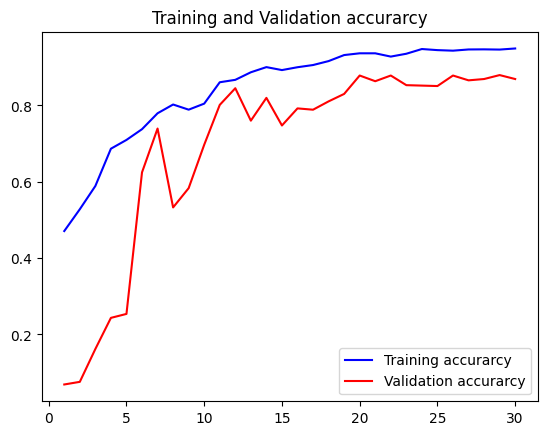

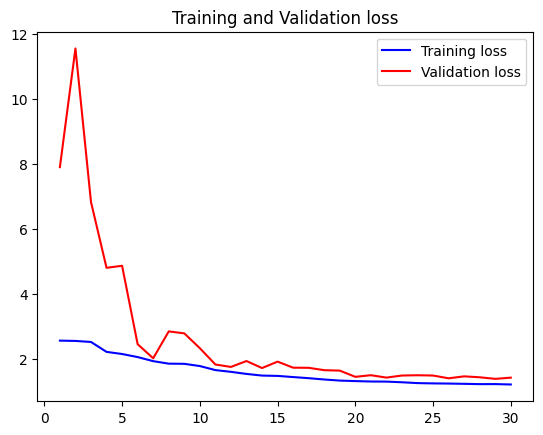

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

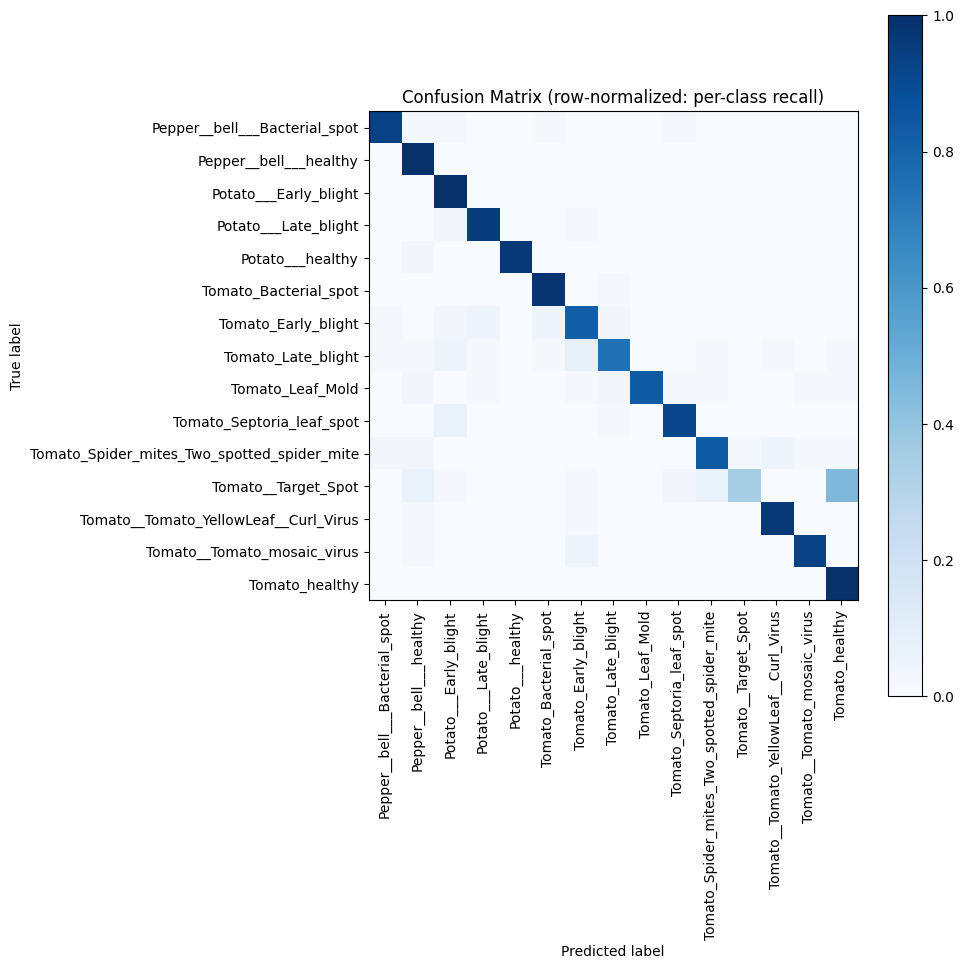

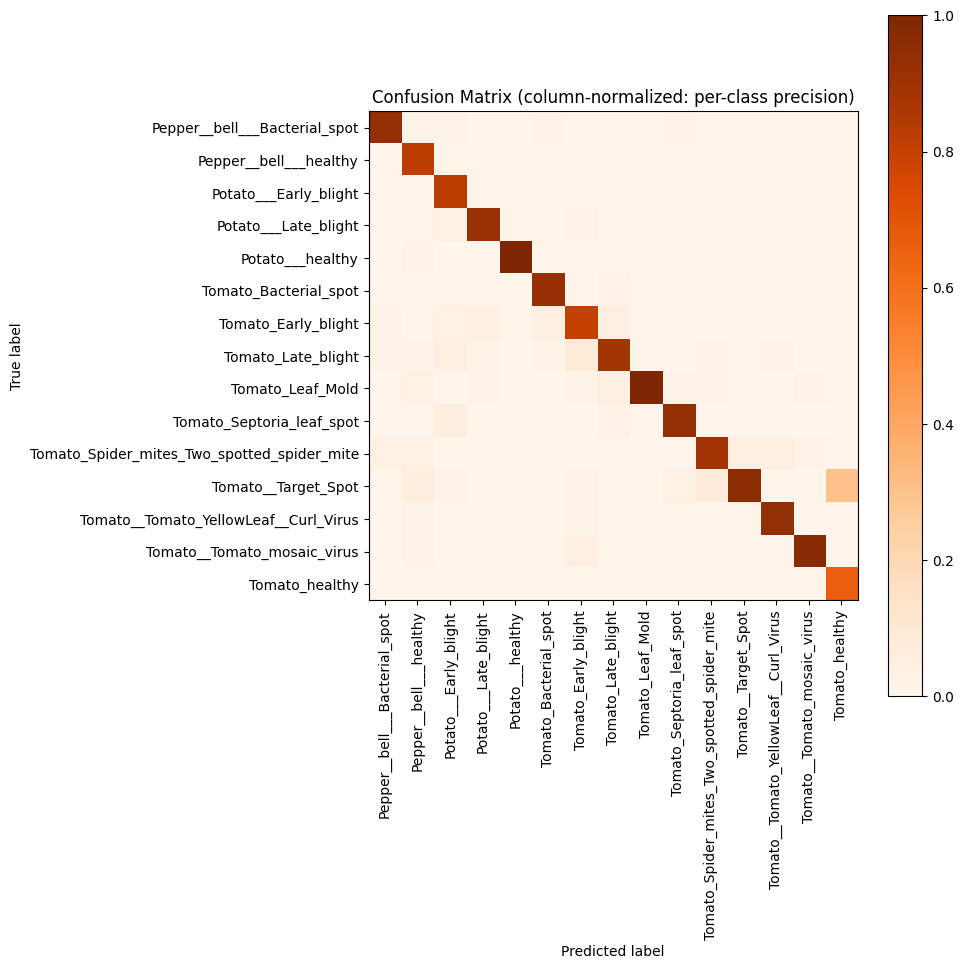

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot      0.933     0.933     0.933        60
                     Pepper__bell___healthy      0.822     1.000     0.902        60
                      Potato___Early_blight      0.822     1.000     0.902        60
                       Potato___Late_blight      0.919     0.950     0.934        60
                           Potato___healthy      1.000     0.968     0.984        31
                      Tomato_Bacterial_spot      0.922     0.983     0.952        60
                        Tomato_Early_blight      0.803     0.817     0.810        60
                         Tomato_Late_blight      0.882     0.750     0.811        60
                           Tomato_Leaf_Mold      1.000     0.833     0.909        60
                  Tomato_Septoria_leaf_spot      0.932     0.917     0.924        60
Tomato_Spider_mites_Two_spotted_spider_mite      0.893     0.833

In [19]:
# Confusion matrix and classification report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# If y_test is one-hot encoded, convert to class indices
y_true = np.argmax(y_test, axis=1)
# Predict class indices
probs = model.predict(x_test, batch_size=BS, verbose=0)
y_pred = np.argmax(probs, axis=1)

labels = list(label_binarizer.classes_)
num_classes = len(labels)

# Normalized by true labels (each row sums to 1): highlights recall per class
cm_true = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="true")
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm_true, display_labels=labels)
disp.plot(include_values=False, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix (row-normalized: per-class recall)")
plt.tight_layout()
plt.show()

# Optional: also view prediction-normalized (each column sums to 1): highlights precision per class
cm_pred = confusion_matrix(y_true, y_pred, labels=range(num_classes), normalize="pred")
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm_pred, display_labels=labels)
disp.plot(include_values=False, cmap="Oranges", ax=ax, xticks_rotation=90, colorbar=True)
ax.set_title("Confusion Matrix (column-normalized: per-class precision)")
plt.tight_layout()
plt.show()

# Full per-class metrics
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# Identify most confused pairs (off-diagonal)
cm_off = cm_true.copy()
np.fill_diagonal(cm_off, 0.0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_off.ravel())[::-1], cm_off.shape))[0]
top_k = 10
print("\nTop confused class pairs (true → predicted) with rates:")
for i, j in pairs[:top_k]:
    if cm_off[i, j] > 0:
        print(f" - {labels[i]} → {labels[j]}: {cm_off[i, j]:.3f}")

In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8794 - loss: 1.3944
Test Accuracy: 87.94488906860352
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8794 - loss: 1.3944
Test Accuracy: 87.94488906860352


In [ ]:
# save the model to disk
print("[INFO] Saving model...")
model.save('plant_disease_cnn.keras')

[INFO] Saving model...


: 